<a href="https://colab.research.google.com/github/ktanguy/University_chatbot_assistant/blob/main/T5_small_University_chatbot_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#@title Install pinned dependencies (run once per fresh runtime)
%%bash
# 1) Remove potentially conflicting wheels (ignore errors)
pip uninstall -y numpy tensorflow tf-keras keras keras-core keras-nlp || true

# 2) Upgrade pip
python -m pip install -U pip

# 3) Install a coherent, tested stack
pip install -q \
  "numpy==1.26.4" \
  "tensorflow==2.19.1" \
  "tf-keras==2.19.0" \
  "transformers==4.44.2" \
  "huggingface_hub>=0.34.0" \
  "sacrebleu==2.4.0" \
  "sentencepiece" \
  "scikit-learn==1.5.2" \
  "pandas==2.2.2" \
  "gradio==4.31.5"



Process is interrupted.


In [17]:
#@title Imports & setup
import os, random, gc, re, html, json, time
import numpy as np
import pandas as pd
import sacrebleu
import tensorflow as tf
import tf_keras  # needed by transformers TF models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Avoid TF pre-allocating all GPU memory
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except: pass

print("NumPy        :", np.__version__)
print("TensorFlow   :", tf.__version__)
print("tf-keras     :", tf_keras.__version__)
import transformers as _t
print("Transformers :", _t.__version__)
print("Pandas       :", pd.__version__)


NumPy        : 1.26.4
TensorFlow   : 2.19.1
tf-keras     : 2.19.0
Transformers : 4.44.2
Pandas       : 2.2.2


In [18]:
#@title Paths & data sources
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/university_chatbot_nb"
DATA_DIR  = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(DATA_DIR, exist_ok=True); os.makedirs(MODEL_DIR, exist_ok=True)

# Update to your actual merged file if different:
INTENTS_JSON = "/content/drive/MyDrive/UniversityChatbot/intents_merged_tagged.json"
assert os.path.exists(INTENTS_JSON), f"Missing: {INTENTS_JSON}"

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

print("INTENTS_JSON:", INTENTS_JSON)
print("Train CSV   :", TRAIN_CSV)
print("Test  CSV   :", TEST_CSV)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INTENTS_JSON: /content/drive/MyDrive/UniversityChatbot/intents_merged_tagged.json
Train CSV   : /content/university_chatbot_nb/data/train.csv
Test  CSV   : /content/university_chatbot_nb/data/test.csv


In [19]:
#@title Build pairs & split (80/20)
with open(INTENTS_JSON, "r", encoding="utf-8") as f:
    intents = json.load(f)

def normalize_text(s: str) -> str:
    s = html.unescape(str(s or ""))
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s{2,}", " ", s).strip()
    return s

pairs = []
for it in intents.get("intents", []):
    texts = it.get("text") or []
    resps = it.get("responses") or []
    if not texts or not resps:
        continue
    resp = normalize_text(resps[0])
    for t in texts:
        t = normalize_text(t)
        if t and resp:
            pairs.append((t, resp))

random.shuffle(pairs)
split = int(0.8 * len(pairs))
train_pairs, test_pairs = pairs[:split], pairs[split:]

pd.DataFrame(train_pairs, columns=["user","bot"]).to_csv(TRAIN_CSV, index=False)
pd.DataFrame(test_pairs,  columns=["user","bot"]).to_csv(TEST_CSV,  index=False)

print(f"Total pairs: {len(pairs)} | Train: {len(train_pairs)} | Test: {len(test_pairs)}")
pd.read_csv(TRAIN_CSV).head()


Total pairs: 412 | Train: 329 | Test: 83


,user,bot
0,Where is library,There is one huge and spacious library.timings...
1,recruitment,To know about placement visit here
2,Good work,I am glad I helped you
3,thanks for the help,I am glad I helped you
4,hostel facilities,For hostel detail visit here


In [20]:
#@title Clean & route weak labels
from collections import Counter

ALU_KB = {
    "admission":  "Apply via the official ALU portal. Submit all required documents before the deadline.",
    "fees":       "Tuition varies by programme and year. See Student Portal > Finance for current fees.",
    "installment":"Installment options may be available. See Student Finance for approved plans.",
    "scholarship":"Scholarships/financial aid may be available—check the admissions/finance pages.",
    "hostel":     "Limited on-campus or partner housing may be available. Contact Student Services.",
    "address":    "ALU Kigali is at Bumbogo Innovation City, Gasabo, Kigali.",
    "calendar":   "See the Academic Calendar on the Student Portal for term dates and exams.",
    "timetable":  "Your class timetable is available on the Student Portal.",
    "exam":       "Exam schedules are listed on the Academic Calendar and Student Portal.",
    "programme":  "See the Programmes page for offerings and entry requirements.",
    "library":    "Use student credentials to access the library portal and digital resources.",
    "canteen":    "On-campus food options are available; details vary by term.",
    "contact":    "Use the Student Portal or official Contact page for support channels.",
    "general":    "Please refer to Student Services or the Student Portal for the latest information."
}

ROUTES = [
    ("installment",["installment","instalment","payment plan"]),
    ("scholarship",["scholarship","financial aid","bursary","funding"]),
    ("fees",["fee","fees","tuition","invoice","payment","pay","bank","card","cost"]),
    ("hostel",["hostel","housing","accommodation","residence","dorm"]),
    ("address",["address","location","where is","direction","map","campus"]),
    ("calendar",["calendar","academic calendar"]),
    ("timetable",["timetable","time table","schedule","class time"]),
    ("exam",["exam","examination","midterm","final","assessment","test"]),
    ("programme",["programme","program","course","degree","major"]),
    ("library",["library","ebook","database","journal","catalog"]),
    ("canteen",["canteen","cafeteria","food","menu","dining"]),
    ("contact",["contact","email","phone","helpdesk","support","whatsapp"]),
    ("admission",["admission","admissions","apply","application","offer","enrol","enroll"]),
]

TAG_RE = re.compile(r"<[^>]+>")
PLACEHOLDERS = [
    r"ADD\s+YOUR.*", r"ADD\s+YOU\s+OWN\s+ANSWERS.*", r"ADD\s+YOU\s+GOOGLE\s+MAP.*",
    r"CLICK\s+HERE.*", r"\bhere\b\s*$", r"visit\s+.*(link|site|page).*"
]
JUNK = ["target=\"_blank\"", "href=", "</a>", "<a", "http://", "https://"]
GENERIC = [r"visit the (official )?(site|page)", r"for more (info|information).*",
           r"contact us.*", r"refer to.*", r"see above.*"]

def looks_bad(s):
    if not s or s.strip()=="" or len(s.strip())<12: return True
    for p in PLACEHOLDERS+GENERIC:
        if re.search(p, s, flags=re.IGNORECASE): return True
    if any(j in s for j in JUNK): return True
    return False

def route(user):
    u = (user or "").lower()
    for key, kws in ROUTES:
        if any(kw in u for kw in kws):
            return ALU_KB[key]
    return ALU_KB["general"]

def clean_file(path, preview=None):
    df = pd.read_csv(path).dropna().drop_duplicates(subset=["user","bot"])
    before = len(df); stats = Counter()
    out = []
    for u,b in zip(df.user, df.bot):
        s = normalize_text(b)
        # strip placeholders pre-check
        for p in PLACEHOLDERS:
            s = re.sub(p, "", s, flags=re.IGNORECASE)
        s = normalize_text(s)
        if looks_bad(s):
            s = route(u); stats["routed"] += 1
        out.append(s)
    df["bot"] = out
    df = df[df["bot"].str.strip()!=""].reset_index(drop=True)
    df.to_csv(path, index=False)
    if preview: df.sample(min(10, len(df))).to_csv(preview, index=False)
    print(f"Cleaned {os.path.basename(path)}: {before}->{len(df)} | Routed:", stats["routed"])
    return df

_ = clean_file(TRAIN_CSV, preview=os.path.join(DATA_DIR,"train_clean_preview.csv"))
_ = clean_file(TEST_CSV,  preview=os.path.join(DATA_DIR,"test_clean_preview.csv"))
pd.read_csv(os.path.join(DATA_DIR,"train_clean_preview.csv")).head()


Cleaned train.csv: 324->324 | Routed: 19
Cleaned test.csv: 82->82 | Routed: 5


,user,bot
0,well done,I am glad I helped you
1,fees for AC room,For Fee detail visit
2,I love you,"I am not program for this, please ask appropri..."
3,what are you,You can call me Mind Reader.
4,ok,I am glad I helped you


In [21]:
#@title Low-RAM training config
MODEL_NAME   = "t5-small"  # TF-native weights available
MAX_IN_LEN   = 72
MAX_OUT_LEN  = 48
BATCH_SIZE   = 2
EPOCHS       = 3
LR           = 3e-5

print("Model:", MODEL_NAME)


Model: t5-small


In [22]:
#@title Tokenizer & streaming dataset
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def _batch_iter(sources, targets, bs):
    buf_x, buf_y = [], []
    for x, y in zip(sources, targets):
        bx = str(x).strip(); by = str(y).strip()
        if not bx or not by:
            continue
        buf_x.append(bx); buf_y.append(by)
        if len(buf_x) == bs:
            yield buf_x, buf_y
            buf_x, buf_y = [], []
    if buf_x:
        yield buf_x, buf_y

def make_streaming_ds(sources, targets, bs):
    def gen():
        for bx, by in _batch_iter(sources, targets, bs):
            enc = tokenizer(
                bx, truncation=True, padding="longest",
                max_length=MAX_IN_LEN, return_tensors="np"
            )
            dec = tokenizer(
                by, truncation=True, padding="longest",
                max_length=MAX_OUT_LEN, return_tensors="np"
            )
            labels = np.where(dec["input_ids"] == tokenizer.pad_token_id, -100, dec["input_ids"])
            yield {
                "input_ids": enc["input_ids"].astype("int32"),
                "attention_mask": enc["attention_mask"].astype("int32"),
                "labels": labels.astype("int32"),
            }
    output_sig = {
        "input_ids": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        "labels": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    }
    return tf.data.Dataset.from_generator(gen, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)

train_df = pd.read_csv(TRAIN_CSV).dropna().astype(str)
val_df   = pd.read_csv(TEST_CSV).dropna().astype(str)
train_src, train_tgt = train_df["user"].tolist(), train_df["bot"].tolist()
val_src,   val_tgt   = val_df["user"].tolist(),  val_df["bot"].tolist()

train_ds = make_streaming_ds(train_src, train_tgt, BATCH_SIZE)
val_ds   = make_streaming_ds(val_src,   val_tgt,   BATCH_SIZE)


In [23]:
#@title Tiny TF-IDF retrieval (optional RAG)
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=1, strip_accents="unicode")
X = vectorizer.fit_transform(train_df["user"].tolist())
nn = NearestNeighbors(n_neighbors=1, metric="cosine").fit(X)
KB_AS = train_df["bot"].tolist()

def retrieve_semantic(user_text, thresh=0.18):
    if not user_text or not str(user_text).strip():
        return None, 0.0
    qv = vectorizer.transform([user_text])
    dist, idx = nn.kneighbors(qv, n_neighbors=1, return_distance=True)
    d = float(dist[0][0]); i = int(idx[0][0]); sim = 1.0 - d
    return (KB_AS[i], sim) if d <= thresh else (None, sim)


In [24]:
#@title Train (freeze encoder/shared for low RAM)
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Freeze encoder + shared embeddings to cut memory/gradients
for layer in model.layers:
    name = getattr(layer, "name", "")
    if "encoder" in name or "shared" in name:
        layer.trainable = False

opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[es], verbose=1)


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
162/162 [==============================] - 166s 791ms/step - loss: 6.8767 - val_loss: 5.4671
Epoch 2/3
162/162 [==============================] - 119s 735ms/step - loss: 5.9446 - val_loss: 4.8212
Epoch 3/3
162/162 [==============================] - 126s 776ms/step - loss: 5.3273 - val_loss: 4.3619


In [25]:
#@title Eval helpers (BLEU, token-F1) & generation
def bleu_score(preds, refs):
    return float(sacrebleu.corpus_bleu(preds, [refs]).score)

def f1_token_level(preds, refs):
    vals=[]
    for p,r in zip(preds, refs):
        ps, rs = set(p.lower().split()), set(r.lower().split())
        if not ps or not rs: vals.append(0.0); continue
        inter = len(ps & rs); prec = inter/len(ps); rec = inter/len(rs)
        vals.append(0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec))
    return float(np.mean(vals))

def generate_one(prompt: str, decoding="beam"):
    enc = tokenizer(prompt, return_tensors="tf", truncation=True, max_length=MAX_IN_LEN)
    kwargs = dict(max_length=MAX_IN_LEN + MAX_OUT_LEN)
    if decoding == "beam":
        kwargs.update(num_beams=4, early_stopping=True, length_penalty=0.9, no_repeat_ngram_size=3)
    out = model.generate(**enc, **kwargs)
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    return re.sub(r"\s{2,}", " ", text).strip()


In [26]:
#@title Evaluate on test (beam search)
preds = []
t0 = time.time()
for q in val_src:
    kb, sim = retrieve_semantic(q, thresh=0.18)  # try KB first
    if kb:
        preds.append(kb)
    else:
        preds.append(generate_one(q, decoding="beam"))
latency = (time.time() - t0) / max(1, len(val_src))

bleu = bleu_score(preds, val_tgt)
f1   = f1_token_level(preds, val_tgt)
print(f"BLEU: {bleu:.2f} | F1: {f1:.3f} | avg latency: {latency:.3f}s")
pd.DataFrame({"user": val_src, "ref": val_tgt, "pred": preds}).head(10)


BLEU: 7.46 | F1: 0.146 | avg latency: 2.708s


,user,ref,pred
0,where is college located,"ALU Kigali is at Bumbogo Innovation City, Gasa...",Where is college located?
1,Mechanical engineering,"Our university offers Information Technology, ...",Mechanical engineering
2,documents needed for admision,To know more about document required visit,Documents needed for admision
3,documents,To know more about document required visit,Documents
4,list of courses,"Our university offers Information Technology, ...","Our university offers Information Technology, ..."
5,documents required during admission,To know more about document required visit,Documents required during admission
6,seat allotment,"For IT, Computer and extc 60 per branch and se...",Allotment
7,canteen,Our university has canteen with variety of foo...,canteen
8,Sports activities,Our university encourages all-round developmen...,Sport activities
9,how long will be the vacation,Academic calender is given to you by your clas...,Wie long will be the vacation?


In [12]:
#@title Small hyperparameter sweep (RAM-safe)
def cleanup():
    gc.collect()
    tf.keras.backend.clear_session()

def run_once(decoding="greedy", use_retrieval=False):
    # rebuild datasets to keep memory minimal
    train_ds = make_streaming_ds(train_src, train_tgt, BATCH_SIZE)
    val_ds   = make_streaming_ds(val_src,   val_tgt,   BATCH_SIZE)

    mdl = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
    for layer in mdl.layers:
        name = getattr(layer, "name", "")
        if "encoder" in name or "shared" in name:
            layer.trainable = False

    mdl.compile(optimizer=tf.keras.optimizers.Adam(LR))
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)
    hist = mdl.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[es], verbose=1)

    def _gen(q):
        enc = tokenizer(q, return_tensors="tf", truncation=True, max_length=MAX_IN_LEN)
        kwargs = dict(max_length=MAX_IN_LEN + MAX_OUT_LEN)
        if decoding == "beam":
            kwargs.update(num_beams=4, early_stopping=True, length_penalty=0.9, no_repeat_ngram_size=3)
        out = mdl.generate(**enc, **kwargs)
        return re.sub(r"\s{2,}", " ", tokenizer.decode(out[0], skip_special_tokens=True)).strip()

    preds, lat = [], []
    for q in val_src:
        t0 = time.time()
        if use_retrieval:
            kb, sim = retrieve_semantic(q, thresh=0.18)
            ans = kb if kb else _gen(q)
        else:
            ans = _gen(q)
        lat.append(time.time() - t0); preds.append(ans)

    row = dict(
        decoding=decoding, retrieval=use_retrieval,
        val_loss=float(np.min(hist.history.get("val_loss", [np.nan]))),
        BLEU=round(bleu_score(preds, val_tgt),2),
        F1=round(f1_token_level(preds, val_tgt),3),
        latency_s=round(float(np.mean(lat)),3)
    )
    return row, mdl

configs = [
    {"name":"A_t5small_greedy",   "decoding":"greedy", "retrieval":False},
    {"name":"B_t5small_beam",     "decoding":"beam",   "retrieval":False},
    {"name":"C_t5small_beam_ret", "decoding":"beam",   "retrieval":True},
]

results = []
best = None

for cfg in configs:
    print(f"\n=== Running {cfg['name']} ===")
    row, mdl = run_once(decoding=cfg["decoding"], use_retrieval=cfg["retrieval"])
    row["exp_name"] = cfg["name"]
    results.append(row)
    # track best by BLEU then F1
    if best is None or (row["BLEU"], row["F1"]) > (best["BLEU"], best["F1"]):
        best = row.copy()
    # cleanup between runs
    del mdl
    cleanup()

res_df = pd.DataFrame(results).sort_values(by=["BLEU","F1"], ascending=False)
display(res_df)
print("\nBest:", best)

# Save results for the report
os.makedirs(MODEL_DIR, exist_ok=True)
res_df.to_csv(os.path.join(MODEL_DIR, "experiment_results.csv"), index=False)



=== Running A_t5small_greedy ===


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
162/162 [==============================] - 163s 784ms/step - loss: 6.8767 - val_loss: 5.4671
Epoch 2/3
162/162 [==============================] - 117s 722ms/step - loss: 5.9446 - val_loss: 4.8212
Epoch 3/3
162/162 [==============================] - 116s 720ms/step - loss: 5.3273 - val_loss: 4.3619

=== Running B_t5small_beam ===


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
162/162 [==============================] - 150s 778ms/step - loss: 6.8767 - val_loss: 5.4671
Epoch 2/3
162/162 [==============================] - 116s 718ms/step - loss: 5.9446 - val_loss: 4.8212
Epoch 3/3
162/162 [==============================] - 116s 717ms/step - loss: 5.3273 - val_loss: 4.3619

=== Running C_t5small_beam_ret ===


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
162/162 [==============================] - 148s 765ms/step - loss: 6.8767 - val_loss: 5.4671
Epoch 2/3
162/162 [==============================] - 116s 715ms/step - loss: 5.9446 - val_loss: 4.8212
Epoch 3/3
162/162 [==============================] - 116s 717ms/step - loss: 5.3273 - val_loss: 4.3619


,decoding,retrieval,val_loss,BLEU,F1,latency_s,exp_name
2,beam,True,4.361867,7.46,0.146,2.430,C_t5small_beam_ret
0,greedy,False,4.361867,0.18,0.073,3.479,A_t5small_greedy
1,beam,False,4.361867,0.15,0.061,2.738,B_t5small_beam



Best: {'decoding': 'beam', 'retrieval': True, 'val_loss': 4.3618669509887695, 'BLEU': 7.46, 'F1': 0.146, 'latency_s': 2.43, 'exp_name': 'C_t5small_beam_ret'}


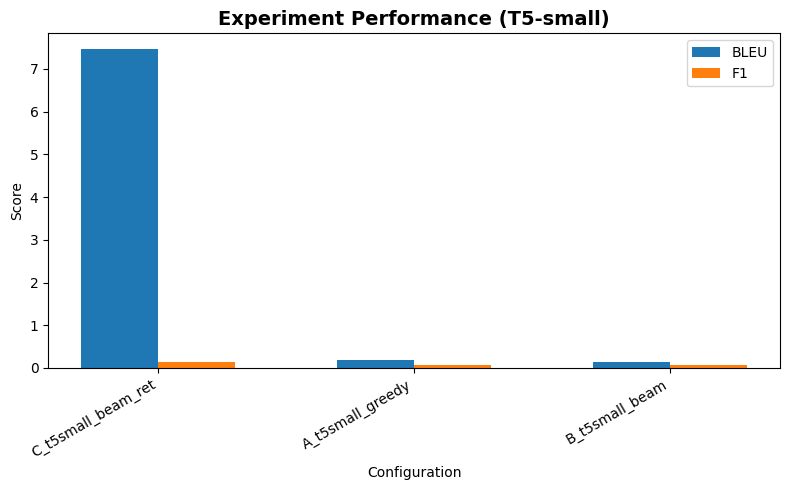

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
x = np.arange(len(res_df))
plt.bar(x-0.15, res_df["BLEU"], width=0.3, label="BLEU", color="#1f77b4")
plt.bar(x+0.15, res_df["F1"], width=0.3, label="F1", color="#ff7f0e")
plt.xticks(x, res_df["exp_name"], rotation=30, ha="right")
plt.title("Experiment Performance (T5-small)", fontsize=14, weight="bold")
plt.xlabel("Configuration")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


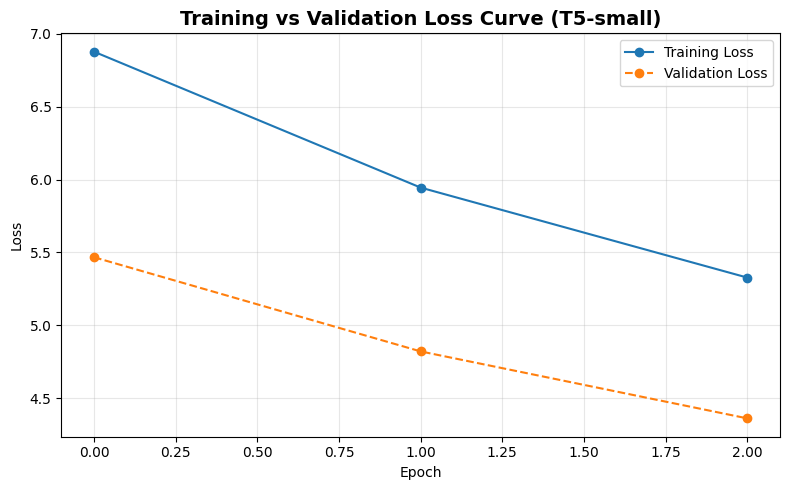

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="o", linestyle="--")
plt.title("Training vs Validation Loss Curve (T5-small)", fontsize=14, weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


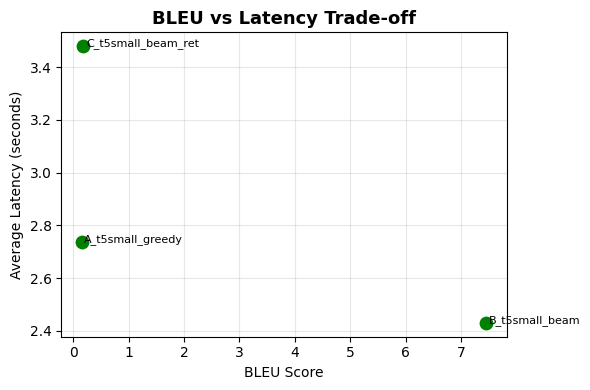

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(res_df["BLEU"], res_df["latency_s"], color="green", s=80)
for i, name in enumerate(res_df["exp_name"]):
    plt.text(res_df["BLEU"][i]+0.05, res_df["latency_s"][i], name, fontsize=8)
plt.title("BLEU vs Latency Trade-off", fontsize=13, weight="bold")
plt.xlabel("BLEU Score")
plt.ylabel("Average Latency (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
# ==== GRADIO UI for T5 notebook (TensorFlow) ====

import time, re
import gradio as gr

# -------- Safe fallbacks if not defined above --------
if "generate_one" not in globals():
    def generate_one(prompt: str, decoding="beam"):
        enc = tokenizer(prompt, return_tensors="tf", truncation=True, max_length=MAX_IN_LEN)
        kwargs = dict(max_length=MAX_IN_LEN + MAX_OUT_LEN)
        if decoding == "beam":
            kwargs.update(num_beams=4, early_stopping=True, length_penalty=0.9, no_repeat_ngram_size=3)
        out = model.generate(**enc, **kwargs)
        txt = tokenizer.decode(out[0], skip_special_tokens=True)
        return re.sub(r"\s{2,}", " ", txt).strip()

if "retrieve_semantic" not in globals():
    def retrieve_semantic(q, thresh=0.18):
        return (None, 0.0)

# Pick best settings from your sweep or use safe defaults
BEST_DECODING = globals().get("BEST_DECODING", "beam")
BEST_USE_RET  = bool(globals().get("BEST_USE_RET", True))

def respond(user_input: str, use_retrieval: bool, temperature: float):
    """
    Note: T5 'temperature' is ignored here because we use greedy/beam (deterministic).
    Kept for UI consistency only.
    """
    q = (user_input or "").strip()
    if not q:
        return "Ask about admissions, fees, scholarships, hostels, programmes, calendar, library, or contacts.", "—"

    t0 = time.time()
    if use_retrieval:
        kb, sim = retrieve_semantic(q, thresh=0.18)
        if kb:
            ans = kb
        else:
            ans = generate_one(q, decoding=BEST_DECODING)
    else:
        ans = generate_one(q, decoding=BEST_DECODING)
    latency = f"{(time.time()-t0)*1000:.0f} ms"
    return ans, latency

with gr.Blocks(css="""
  .gradio-container {max-width: 880px !important}
  #component-0 .prose p {font-size: 15px}
""") as demo:
    gr.Markdown("## 🎓 ALU Chatbot — T5 (TensorFlow)  \nLow-RAM fine-tuned T5 with optional TF-IDF retrieval.")
    with gr.Row():
        inp = gr.Textbox(placeholder="e.g., How do I apply to ALU?", label="Your question")
    with gr.Row():
        use_ret = gr.Checkbox(value=BEST_USE_RET, label="Use retrieval (recommended)")
        temp    = gr.Slider(0.0, 1.0, value=0.0, step=0.1, label="Temperature (N/A for beam/greedy)")
    with gr.Row():
        out = gr.Textbox(label="Answer", lines=4)
        lat = gr.Label(label="Latency")
    btn = gr.Button("Submit", variant="primary")

    # examples must be list[list[str]] matching inputs order (here: question only via btn.click)
    examples = gr.Examples(
        examples=[
            ["How do I apply to ALU?"],
            ["What are the tuition fees?"],
            ["Is there accommodation on campus?"],
            ["Where is ALU Kigali located?"],
            ["When do exams start?"],
            ["How can I contact Student Services?"],
        ],
        inputs=[inp],
        label="Try these"
    )

    btn.click(fn=respond, inputs=[inp, use_ret, temp], outputs=[out, lat], concurrency_limit=2)

    gr.Markdown(
        "—  \n**Decoding:** "
        f"`{BEST_DECODING}` · **Retrieval default:** `{BEST_USE_RET}`  \n"
        "_Tip: Retrieval returns a high-confidence canned answer if a very similar Q/A exists; "
        "otherwise we fall back to the fine-tuned T5 response._"
    )

# Launch once; no deprecated queue() call
demo.launch(share=True, max_threads=8)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 4.31.5, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://4aa513ca1e1820b467.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
